# Model training notebook
    1) Baseline XGboost with mean aggregation (std and max also possible)
    2) Model XGBoost time-series linear fit and imbalance correction
    
    Note: All risk to leave predictions are done on a N+1 basis
    
    Author: Nelson Fernandez Pinto
            @nfsrules
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('filtered_dataset.csv', index_col=0)

### Linear fit functions

In [17]:
def linear_fit(data, x_var, y_var, fillna_method='bfill'):
    '''Fit a linear regression model of type X*COEF + INTERCEPT
    Inputs
        data: Pandas dataframe of user
        x_var: Variable name of x-axis (normally time-based months)
        y_var: Variable to fit
        fillna_method: If nan fill with next non NaN value (only method supported)
    '''
    # Fit a linear regression mode respecting sklearn input shape
    reg = LinearRegression().fit(data[x_var].values.reshape(-1, 1),
                                 data[y_var].fillna(method=fillna_method).values.reshape(-1, 1))

    return reg.coef_, reg.intercept_


def linear_fit_group(group):
    '''Estimate linear fit for all variables of 
    a single user.
    Inputs
        group: Pandas dataframe 
    Return
        Pandas dataframe with user linear fit
    '''
    group_coef = []
    group_intercept = []
    group_varname = []

    for var_name in group.columns:

        if not type(group[var_name].values[-1]) == str: # if variable does not contains an string
            if not var_name == 'MONTH': # if y is not x 
                coef, intercept = linear_fit(group.dropna(subset=[var_name]), 
                                             'MONTH', # always X-axis time series
                                              var_name, # time series to fit
                                             'bfill') # if there are NaNs complete with next available value
                # Fill list with new variables
                group_coef.append(float(coef))
                group_intercept.append(float(intercept))
                group_varname.append(var_name)

    # Built dataset of 1 group 2x variables
    group_coef = pd.DataFrame(group_coef).T
    group_coef.columns = [ i + '_COEF'  for i in group_varname]
    group_intercept = pd.DataFrame(group_intercept).T
    group_intercept.columns = [ i + '_INTERCEPT'  for i in group_varname]
    group_df = pd.concat([group_coef, group_intercept], 1)
    
    return group_df


def compute_linear_df(df):
    '''Create a new dataset where every time series variable
    has been modelized with a linear fit: COEF, INTERCEPT
    Inputs
        Pandas dataframe with time-series variables
    Retunts
        Pandas dataframe with linear fit of time-series variables
    
    '''
    linear_df = []
    for name, group in tqdm(df.groupby('ENTITY_ID')):
        linear_df.append(linear_fit_group(group))

    linear_df = pd.concat(linear_df)
    linear_df['ENTITY_ID'] = df.ENTITY_ID.unique()
    linear_df.index = np.arange(linear_df.shape[0])
    
    return linear_df


### Model Python class Estimator()

In [60]:
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import metrics


class Estimator():
    def __init__(self, df, kind='mean', random_state=42, stratify=True, 
                 imbalanced=True, nrb_estimators=100, roc=True, top_n_features=5):
        
        self.df = df
        self.random_seed = random_state
        self.stratify = stratify
        self.imbalanced = imbalanced
        self.nrb_estimators = nrb_estimators
        self.roc = roc
        self.top_n_features = top_n_features
        
        # Start aggregation pipeline
        print('Preparing dataset...')
        if kind == 'mean':
            self.X = df.groupby('ENTITY_ID').mean().drop(columns=['TARGET']).reset_index()
        elif kind == 'std':
            self.X = df.groupby('ENTITY_ID').std().drop(columns=['TARGET']).reset_index()
        elif kind == 'max':
            self.X = df.groupby('ENTITY_ID').max().drop(columns=['TARGET']).reset_index()
        elif kind == 'linear':
            self.X = compute_linear_df(df).drop(columns=['TARGET_COEF', 'TARGET_INTERCEPT'])
        else:
            raise('Only mean, std, linear are allowed')

        self.y = df.groupby('ENTITY_ID').TARGET.max()
        
        # Train test split data (stratified)
        print('Creating partition')
        if stratify:
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                                stratify=self.y, 
                                                                random_state=random_state)
        else:
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                                random_state=random_state)
        # Parsing partition to class
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Create XGBoost model
        if imbalanced:
            # Set optimal error of umbalanced class
            scale_pos_weight = y_train[y_train == 0].shape[0] / sum(y_train)
            self.model = xgb.XGBClassifier(use_label_encoder=False,
                                          val_metric='binary:logistic',
                                          random_state=7,
                                          max_depth= None,
                                          n_estimators=nrb_estimators,
                                          scale_pos_weight=scale_pos_weight)
        else:
            self.model = xgb.XGBClassifier(use_label_encoder=False,
                                          val_metric='binary:logistic',
                                          random_state=7,
                                          max_depth= None,
                                          n_estimators=nrb_estimators,
                                          scale_pos_weight=1)
        
        print('Train total samples: {}, Class 1: {}, Class 0: {}, Ratio: {}'.format(y_train.shape[0],
                                                                               sum(y_train),
                                                                               y_train.shape[0]-sum(y_train),
                                                                               str(sum(y_train)*100/y_train.shape[0])+'%'
                                                                                 ))
        print('Test total samples: {}, Class 1: {}, Class 0: {}, Ratio: {}'.format(y_test.shape[0],
                                                                               sum(y_test),
                                                                               y_test.shape[0]-sum(y_test),
                                                                               str(sum(y_test)*100/y_test.shape[0])+'%'
                                                                                 ))
            
    def train(self):
        print('Training XGB estimator...')
        self.model.fit(self.X_train.drop(columns=['ENTITY_ID']), self.y_train)
        print('Model trained')
        
        
    def evaluate(self):
        # Get prediction on test set
        y_pred = self.model.predict(self.X_test.drop(columns=['ENTITY_ID']))
        self.y_test_pred = y_pred
        
        # Compute precision and recall
        prec, recall, support, beta = precision_recall_fscore_support(self.y_test, y_pred, 
                                                                       average='binary',
                                                                       labels= ['0', '1'])
        print('Precision: {}%, Recall: {}%'.format(prec*100, recall*100))
        
        # Get the top 5 most relevant features (dataframe)
        xai_df = pd.DataFrame(self.model.feature_importances_).T
        xai_df.columns = self.X_test.drop(columns=['ENTITY_ID']).columns
        xai_df = xai_df.T.sort_values(by=0, ascending=False)
        topn_features_name = xai_df.iloc[:self.top_n_features].index.values
        print('Feature importance', xai_df)
        
        # Plot confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        print('CM', cm)
        sns.heatmap(cm)
        
        # Plot ROC curve
        metrics.plot_roc_curve(self.model, self.X_test.drop(columns=['ENTITY_ID']), self.y_test) 
        
        ## Study TPR per months
        # Filter only the top N-relevant variables
        df_test_topn = self.X_test[topn_features_name]
        df_test_topn['CLASS'] = self.y_test.values
        self.df_test_topn = df_test_topn
        
        # Find the AGE index column for every user in test set
        test_ages_index = [self.df.groupby('ENTITY_ID').AGE.max().reset_index().index[index] for 
                         index in df_test_topn.index.values]
                
        test_ages = [self.df.groupby('ENTITY_ID').AGE.max().iloc[index] for index in test_ages_index]
        df_test_topn['AGE'] = test_ages
        df_test_topn['PRED'] = y_pred
        
        # Estimate the distribution of class 1
        # Split in 25, 50, 75% quantiles
        dist = df_test_topn[df_test_topn.CLASS == 1].AGE.describe()
        per25_ = dist[4]
        per50_ = dist[5]
        per75_ = dist[6]

        # Performance of class 1 per AGE
        perf_25 = df_test_topn[(df_test_topn.CLASS == 1) &
                               (df_test_topn.AGE <= per25_)]
        perf_25 = sum(perf_25.CLASS == perf_25.PRED)/perf_25.shape[0]
        print('Acc AGE <= {} months: {}%'.format(per25_, perf_25*100))


        perf_50 = df_test_topn[(df_test_topn.CLASS == 1) &
                               (df_test_topn.AGE > per25_) &
                               (df_test_topn.AGE <= per50_)]
        perf_50 = sum(perf_50.CLASS == perf_50.PRED)/perf_50.shape[0]
        print('Acc AGE > {} and <= {} months: {}%'.format(per25_, 
                                                per50_,
                                                perf_50*100))

        perf_75 = df_test_topn[(df_test_topn.CLASS == 1) &
                               (df_test_topn.AGE > per50_) &
                               (df_test_topn.AGE <= per75_)]
        perf_75 = sum(perf_75.CLASS == perf_75.PRED)/perf_75.shape[0]
        print('Acc AGE > {} and <= {} months: {}%'.format(per50_, 
                                                per75_,
                                                perf_75*100))

        perf_100 = df_test_topn[(df_test_topn.CLASS == 1) &
                               (df_test_topn.AGE > per75_)]
        perf_100 = sum(perf_100.CLASS == perf_100.PRED)/perf_100.shape[0]

        print('Acc AGE > {} months: {}%'.format(per75_, 
                                               perf_100*100))



## I) Baseline XGboos w/ mean time series aggregation

In [52]:
baseline = Estimator(df, kind='mean', imbalanced=False)

Preparing dataset...
Creating partition
Train total samples: 3570, Class 1: 681, Class 0: 2889, Ratio: 19.07563025210084%
Test total samples: 1190, Class 1: 227, Class 0: 963, Ratio: 19.07563025210084%


In [53]:
baseline.train()

Training XGB estimator...
[19:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "val_metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model trained


Precision: 86.38743455497382%, Recall: 72.68722466960352%
Feature importance                                     0
DELTA_LAST_INVOICE_LOAD      0.220707
FIX_MRR                      0.098361
VAR_MRR                      0.085506
MONTH                        0.083406
AVERAGE_TIME_PER_USER        0.078726
USERS_PER_FTE                0.069078
ACTIVE_USERS_PER_FTE         0.062764
VAR_MRR_PER_FTE              0.056333
AMOUNT_PAY_PER_ACTIVE_USERS  0.054161
FTE_AGG                      0.052631
LAST_LOAD_DATE               0.037879
NB_ACTIVE_PLASTIC_CARDS      0.037145
COUNT_PAY_PER_ACTIVE_USERS   0.031722
FIRST_LOAD_DATE              0.031582
AGE                          0.000000
CM [[937  26]
 [ 62 165]]


/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Acc AGE <= 6.0 months: 70.96774193548387%
Acc AGE > 6.0 and <= 12.0 months: 77.35849056603774%
Acc AGE > 12.0 and <= 23.0 months: 84.48275862068965%
Acc AGE > 23.0 months: 57.407407407407405%


/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


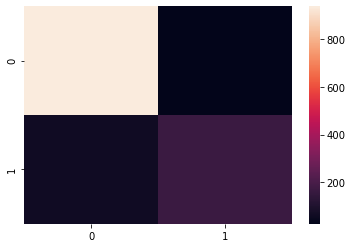

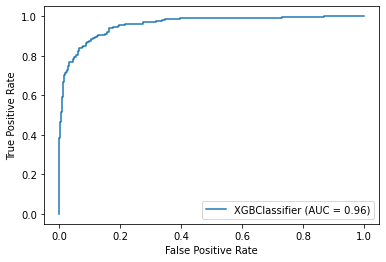

In [54]:
baseline.evaluate()

## II) XGboost time-series linear fit & imbalance class correction


In [61]:
model = Estimator(df, kind='linear', imbalanced=True)

  0%|          | 0/4760 [00:00<?, ?it/s]

Preparing dataset...


100%|██████████| 4760/4760 [02:44<00:00, 28.99it/s]


Creating partition
Train total samples: 3570, Class 1: 681, Class 0: 2889, Ratio: 19.07563025210084%
Test total samples: 1190, Class 1: 227, Class 0: 963, Ratio: 19.07563025210084%


In [62]:
model.train()

Training XGB estimator...
[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "val_metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model trained


Precision: 92.55813953488372%, Recall: 87.66519823788546%
Feature importance                                               0
VAR_MRR_COEF                           0.346284
AGE_COEF                               0.104725
FIX_MRR_COEF                           0.079235
DELTA_LAST_INVOICE_LOAD_INTERCEPT      0.065144
USERS_PER_FTE_COEF                     0.054045
ACTIVE_USERS_PER_FTE_COEF              0.046642
LAST_LOAD_DATE_INTERCEPT               0.032620
AGE_INTERCEPT                          0.031081
FIX_MRR_INTERCEPT                      0.028235
COUNT_PAY_PER_ACTIVE_USERS_COEF        0.021852
VAR_MRR_PER_FTE_COEF                   0.020500
AVERAGE_TIME_PER_USER_INTERCEPT        0.019874
VAR_MRR_PER_FTE_INTERCEPT              0.019708
NB_ACTIVE_PLASTIC_CARDS_COEF           0.016510
AMOUNT_PAY_PER_ACTIVE_USERS_INTERCEPT  0.016001
ACTIVE_USERS_PER_FTE_INTERCEPT         0.015108
FTE_AGG_INTERCEPT                      0.014950
VAR_MRR_INTERCEPT                      0.014361
NB_ACTIVE_P

/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Acc AGE <= 6.0 months: 83.87096774193549%
Acc AGE > 6.0 and <= 12.0 months: 88.67924528301887%
Acc AGE > 12.0 and <= 23.0 months: 96.55172413793103%
Acc AGE > 23.0 months: 81.48148148148148%


/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nfsrules/opt/anaconda3/envs/NewPytorch/lib/python3.7/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


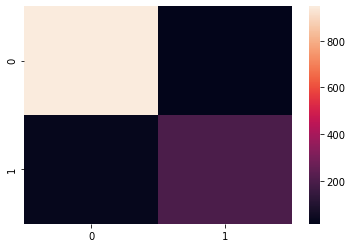

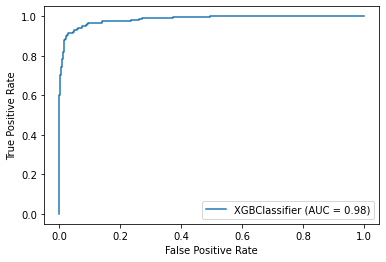

In [63]:
model.evaluate()

In [65]:
# Save training dataset
#model.X_train.to_csv('X_train_linear.csv')
#model.y_train.to_csv('y_train_linear.csv')

# Save test dataset and predictions
#pd.DataFrame(model.y_test_pred).to_csv('y_test_linear_pred.csv')
#model.y_test.to_csv('y_test_linear_true.csv')
#model.X_test.to_csv('X_test_linear.csv')